In [27]:
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [10]:
PROJECT_DIR = Path("/Users/jonas/Documents/Bachelorarbeit/injection_molding_simulation")
EXPERIMENT_DIR = PROJECT_DIR / "experiments" / "find_false_negatives"
SRC_DIR = PROJECT_DIR / "src"

In [11]:
sys.path.append(str(SRC_DIR))
from dataset import InjectionMoldingDataset

In [4]:
torch.manual_seed(42)
dataset = InjectionMoldingDataset(0.004, 0.03, skip_processing=True)
dataset = dataset.shuffle()[:1000]
test_dataset = dataset[800:]

In [5]:
model = torch.load(EXPERIMENT_DIR / "models_baseline" / "model_epoch_9.pt")

In [26]:
num_false_negatives = []
for i, d in tqdm(enumerate(test_dataset), total=len(test_dataset)):
    with torch.no_grad():
        out = model(d)
        y_pred = F.softmax(out, dim=1)[:, 0].round()
        y_true = d.y[:, 0]
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        num_false_negatives.append(fn)

100%|██████████| 200/200 [05:40<00:00,  1.70s/it]


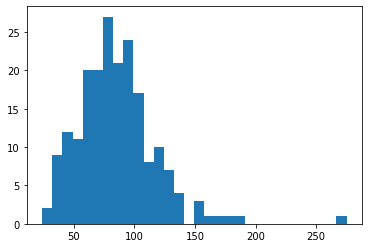

In [33]:
plt.figure()
plt.hist(num_false_negatives, bins=30)
plt.show()

In [193]:
pd.DataFrame(num_false_negatives, columns=["num_false_negatives"]).describe()

,num_false_negatives
count,200.000000
mean,85.380000
std,32.382538
min,24.000000
25%,64.000000
50%,82.000000
75%,101.000000
max,275.000000


In [142]:
index_fn = list(zip(list(range(len(num_false_negatives))), num_false_negatives))
sorted_index_fn = sorted(index_fn, key=lambda x: x[1])
print(sorted_index_fn)

[(120, 24), (133, 28), (147, 33), (171, 36), (47, 37), (87, 38), (118, 38), (127, 38), (123, 39), (159, 39), (46, 40), (3, 44), (10, 44), (142, 44), (69, 45), (61, 46), (187, 46), (2, 47), (84, 47), (124, 47), (158, 47), (119, 48), (194, 48), (36, 50), (82, 50), (33, 51), (121, 52), (156, 52), (42, 53), (152, 53), (26, 55), (109, 56), (122, 56), (192, 57), (167, 58), (190, 58), (0, 59), (72, 60), (125, 60), (150, 60), (151, 60), (154, 60), (15, 61), (62, 61), (149, 61), (162, 61), (73, 62), (126, 62), (95, 63), (9, 64), (27, 64), (39, 64), (134, 64), (177, 64), (7, 66), (168, 66), (6, 67), (38, 67), (43, 67), (12, 69), (98, 69), (100, 69), (50, 70), (75, 70), (170, 70), (185, 70), (18, 71), (71, 71), (195, 71), (70, 72), (90, 72), (148, 73), (178, 73), (198, 73), (17, 75), (28, 75), (92, 75), (107, 75), (108, 75), (1, 76), (49, 76), (89, 76), (137, 76), (172, 76), (146, 77), (161, 77), (8, 78), (51, 78), (101, 78), (105, 78), (165, 78), (16, 79), (22, 79), (23, 79), (79, 79), (116, 79)

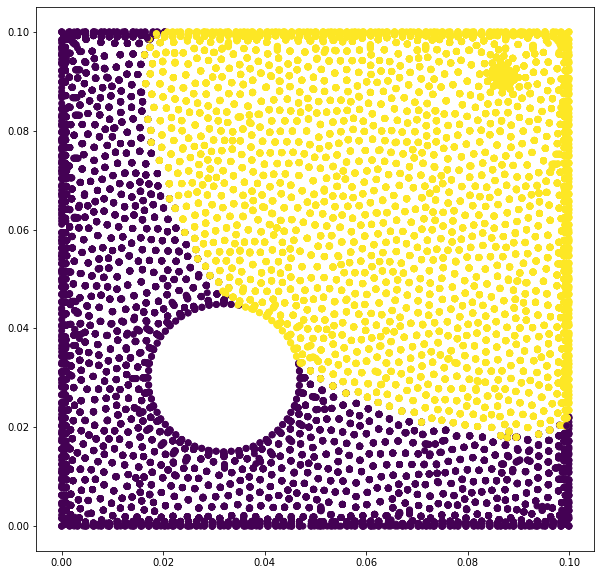

In [167]:
rank = 12
index = sorted_index_fn[rank][0]
xs, ys, zs = test_dataset[index].pos.T
fs = test_dataset[index].y[:, 0]
plt.figure(figsize=(10, 10))
plt.scatter(xs, ys, c=fs)
plt.show()

In [174]:
filled_nodes = [d.y[:, 0].sum().item() / len(d.y[:, 0]) for d in tqdm(test_dataset)]

100%|██████████| 200/200 [00:06<00:00, 31.48it/s]


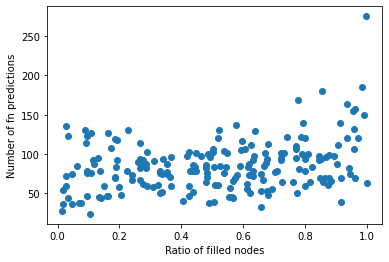

In [182]:
plt.figure()
plt.scatter(filled_nodes, num_false_negatives)
plt.xlabel("Ratio of filled nodes")
plt.ylabel("Number of fn predictions")
plt.show()

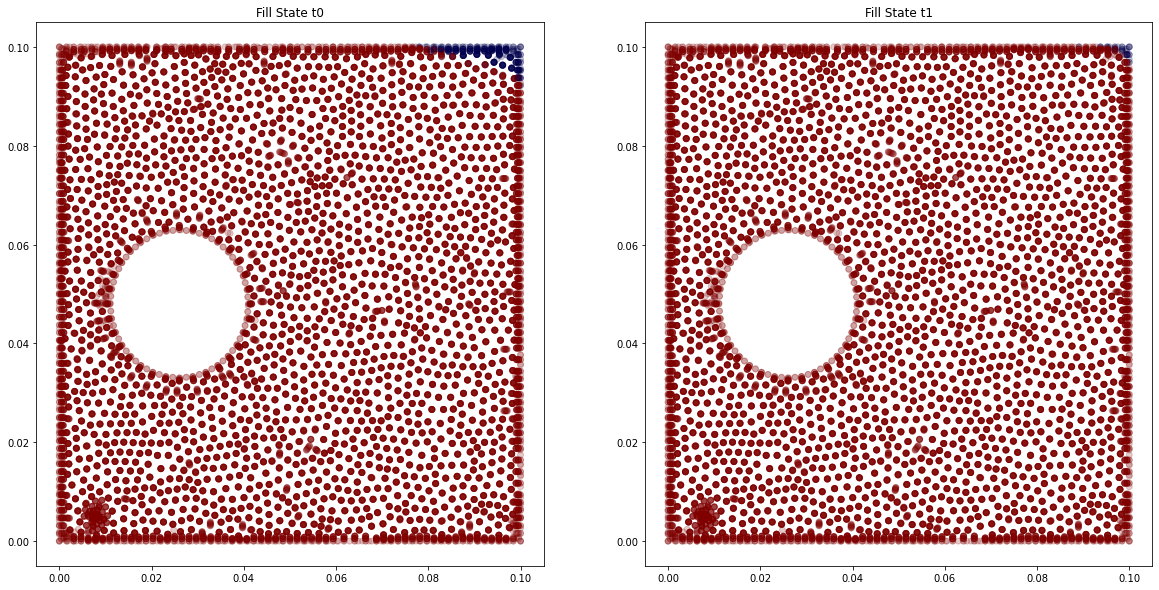

In [67]:
# fill visualization
max_fn_d = test_dataset[99]
xs, ys, zs = max_fn_d.pos.T
fs_t0 = max_fn_d.x[:, 0]
fs_t1 = max_fn_d.y[:, 0]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
ax_left, ax_right = axes
ax_left.set_title("Fill State t0")
ax_left.scatter(xs, ys, c=fs_t0, alpha=0.2, cmap="seismic")

ax_right.set_title("Fill State t1")
ax_right.scatter(xs, ys, c=fs_t1, alpha=0.2, cmap="seismic")
plt.show()

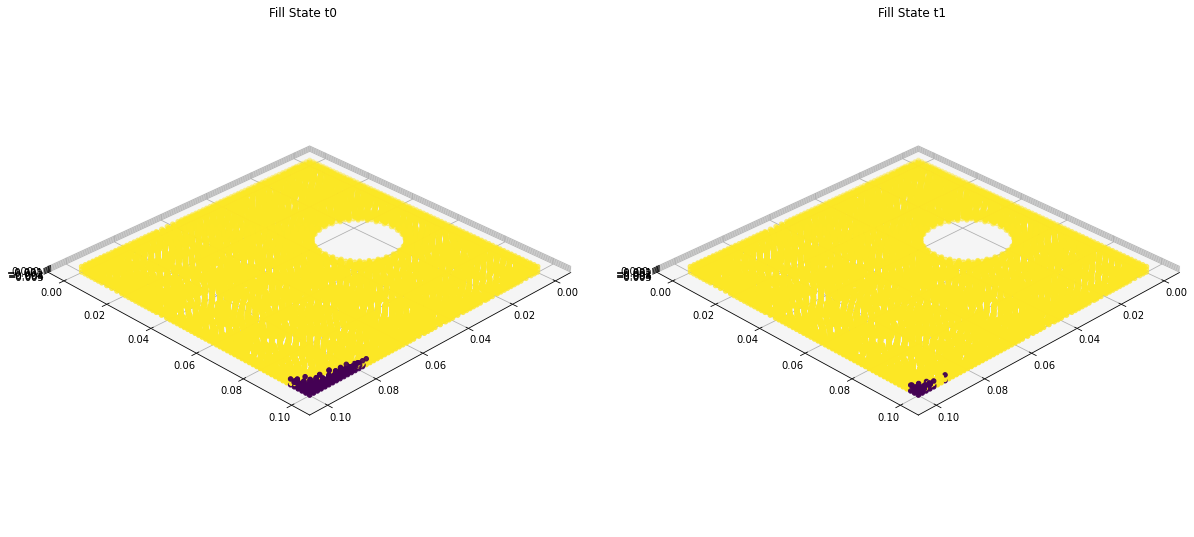

In [114]:
max_fn_d = test_dataset[99]

xs, ys, zs = max_fn_d.pos.T
fill_state_t0 = max_fn_d.x[:, 0]
fill_state_t1 = max_fn_d.y[:, 0]

ROTATION = 45
ELEVATION = 30

fig = plt.figure(figsize=[20, 10])

ax_left = fig.add_subplot(121, projection="3d")
ax_left.set_title("Fill State t0")
ax_left.view_init(elev=ELEVATION, azim=ROTATION)
ax_left.set_box_aspect([1, 1, .02])
ax_left.scatter(xs, ys, zs, c=fill_state_t0)

ax_right = fig.add_subplot(122, projection="3d")
ax_right.set_title("Fill State t1")
ax_right.view_init(elev=ELEVATION, azim=ROTATION)
ax_right.set_box_aspect([1, 1, .02])
ax_right.scatter(xs, ys, zs, c=fill_state_t1)

plt.show()

torch.Size([382, 3])


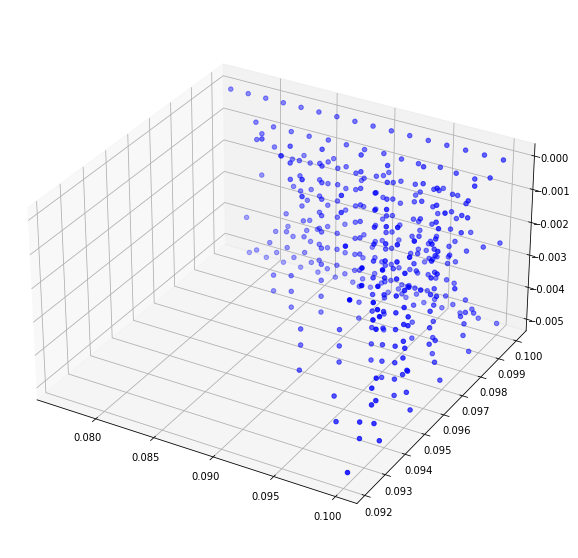

In [138]:
max_fn_d = test_dataset[99]
not_filled = max_fn_d.x[:, 1].bool().view(-1, 1).expand(-1, 3)
not_filled_pos = max_fn_d.pos[filled].view(-1, 3)
print(not_filled_pos.shape)

xs, ys, zs = not_filled_pos.T

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect([1, 1, .6])
ax.scatter(xs, ys, zs, color="blue")
plt.show()

275


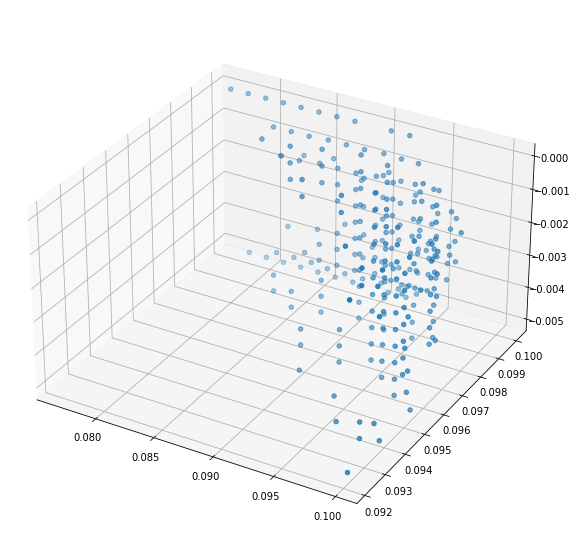

In [137]:
max_fn_d = test_dataset[99]
out = model(max_fn_d).detach()
y_pred = F.softmax(out, dim=1).round()[:, 0].bool().numpy()
y_true = max_fn_d.y[:, 0].bool().numpy()
x = max_fn_d.x[:, 0].bool().numpy()
false_negative = np.logical_and((y_pred != y_true), np.logical_not(y_pred))

xs, ys, zs = max_fn_d.pos[false_negative, :].T
print(len(xs))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
ax.set_box_aspect([1, 1, .6])
ax.scatter(xs, ys, zs)

plt.show()